In [59]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
import matplotlib.pyplot as plt
import os, shutil
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

from KAGGLE_NLP_with_disaster_tweets.model import base_model, utils
from KAGGLE_NLP_with_disaster_tweets.data_preparation.utils import DataPipeline, BatchPipeline

os.environ["CUDA_VISIBLE_DEVICES"]="-1"

log_dir = f'./logs/hyperparameter_tuning_BaseModel/'

try:
    # clearing logging directory
    shutil.rmtree(log_dir)
except NotADirectoryError:
    pass

if not os.path.exists(log_dir):
    os.makedirs(log_dir)

In [61]:
train_file_name = 'train.csv'
test_file_name = 'test.csv'
sample_submission_file_name = 'sample_submission.csv'

vocabulary_size = 16764

data_pipeline = DataPipeline(train_file_name, test_file_name, sample_submission_file_name, output_sequence_length=30, vocabulary_size=vocabulary_size)
dataset = data_pipeline.prepare_dataset(include_cols=["location", "keyword"], apply_preprocessing=True)

Getting the file: ../data/train.csv
Dataframe size before eliminating too short texts: 7613
Dataframe size after eliminating too short texts: 7462
         id keyword location  \
0         1                    
1         4                    
2         5                    
3         6                    
4         7                    
...     ...     ...      ...   
7608  10869                    
7609  10870                    
7610  10871                    
7611  10872                    
7612  10873                    

                                                   text  target  
0     our deeds are the reason of this earthquake ma...       1  
1                 forest fire near la ronge sask canada       1  
2     all residents asked to shelter in place are be...       1  
3      people receive wildfires evacuation orders in...       1  
4     just got sent this photo from ruby alaska as s...       1  
...                                                 ...     ...  
7608  

In [62]:
dataframe = data_pipeline.dataframe
isTrueCount = dataframe["target"].where(dataframe["target"] == 1).count()
isFalseCount = dataframe["target"].where(dataframe["target"] == 0).count()
print(f"True instances: {isTrueCount} | {100 * isTrueCount / (isTrueCount + isFalseCount)}% of data")
print(f"False instances: {isFalseCount} | {100 * isFalseCount / (isTrueCount + isFalseCount)}% of data")

True instances: 3225 | 43.218976145805414% of data
False instances: 4237 | 56.781023854194586% of data


In [63]:
balanced_class_weights = utils.get_balanced_class_weights(dataframe)

In [64]:
from tensorboard.plugins.hparams import api as hp

batch_size = 64
epochs = 10
log_directory = "./logs/hyperparameter_tuning_BaseModel/"

# create a dict to keep the hyperparameters
hparams = {
    hp.HParam("optimizer", hp.Discrete(["adamw"])): "adamw",
    hp.HParam("batch_size", hp.Discrete([16, 32, 64])): batch_size,
    hp.HParam("learning_rate", hp.RealInterval(1e-5, 1e-3)): 1e-4,
    hp.HParam("class_weights", hp.Discrete(["none", "balanced"])): "balanced",
    hp.HParam("dropout", hp.Discrete([0.1, 0.9])): 0.5
}
# easier to manage hyperparameters with this wrapper class
hyperparameter_manager = utils.HyperparameterManager(hparams=hparams)

In [65]:
model = base_model.BaseModel(
    vocabulary_size=vocabulary_size,
    embedding_dim=128,
    hidden_dim=128, # with 64, we got 0.80 val acc
    lstm_dim=64,
    n_labels=2,
    encoder=data_pipeline.input_vectorizer,
    epochs=10,
    batch_pipeline=BatchPipeline(dataset, batch_size),
    hparam_manager=hyperparameter_manager,
    class_weights=balanced_class_weights)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 128)         2145792   
                                                                 
 dropout_4 (Dropout)         (None, None, 128)         0         
                                                                 
 bidirectional_4 (Bidirectio  (None, None, 128)        98816     
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, None, 128)         16512     
                                                                 
 global_average_pooling1d_4   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_9 (Dense)             (None, 2)                

## Overfitting for sanity check

In [66]:
debugging_dataset = dataset.take(2).batch(2)
model.test_model(debugging_dataset, 10)

Epoch 1/10
1/1 [==============================] - 9s 9s/step - loss: 0.6956 - accuracy: 0.0000e+00 - val_loss: 0.6922 - val_accuracy: 1.0000
Epoch 2/10
1/1 [==============================] - 0s 183ms/step - loss: 0.6906 - accuracy: 1.0000 - val_loss: 0.6922 - val_accuracy: 1.0000
Epoch 3/10
1/1 [==============================] - 0s 173ms/step - loss: 0.6926 - accuracy: 0.5000 - val_loss: 0.6922 - val_accuracy: 1.0000
Epoch 4/10
1/1 [==============================] - 0s 188ms/step - loss: 0.6926 - accuracy: 1.0000 - val_loss: 0.6921 - val_accuracy: 1.0000
Epoch 5/10
1/1 [==============================] - 0s 175ms/step - loss: 0.6943 - accuracy: 0.5000 - val_loss: 0.6920 - val_accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 0s 169ms/step - loss: 0.6874 - accuracy: 1.0000 - val_loss: 0.6919 - val_accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 0s 167ms/step - loss: 0.6907 - accuracy: 1.0000 - val_loss: 0.6918 - val_accuracy: 1.0000
Epoch 8/10
1/1 [===

## Train the dataset

In [67]:
accuracy, precision, recall, f1, predictions1 = model.fit_and_evaluate(log_directory=log_directory)
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1-Score: {f1}")

run -> __lr=0.0001__batch_size=64__optimizer=adamw__class_weights=balanced__dropout=0.5 starting...
Epoch 1/10
69/69 [==============================] - 10s 84ms/step - loss: 0.7168 - accuracy: 0.5532 - val_loss: 0.6887 - val_accuracy: 0.5571
Epoch 2/10
69/69 [==============================] - 3s 46ms/step - loss: 0.6975 - accuracy: 0.5697 - val_loss: 0.6752 - val_accuracy: 0.5571
Epoch 3/10
69/69 [==============================] - 3s 48ms/step - loss: 0.6516 - accuracy: 0.5709 - val_loss: 0.6494 - val_accuracy: 0.5659
Epoch 4/10
69/69 [==============================] - 3s 50ms/step - loss: 0.5850 - accuracy: 0.6581 - val_loss: 0.5895 - val_accuracy: 0.7228
Epoch 5/10
69/69 [==============================] - 3s 50ms/step - loss: 0.5186 - accuracy: 0.7944 - val_loss: 0.5335 - val_accuracy: 0.7779
Epoch 6/10
69/69 [==============================] - 3s 49ms/step - loss: 0.4528 - accuracy: 0.8322 - val_loss: 0.4944 - val_accuracy: 0.7894
Epoch 7/10
69/69 [==============================] - 4

## Visualize accuracy and loss

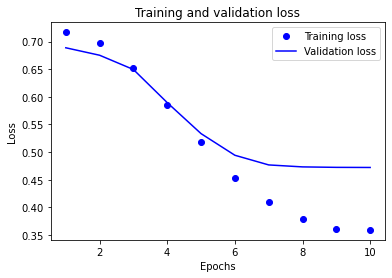

In [68]:
history_dict = model.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

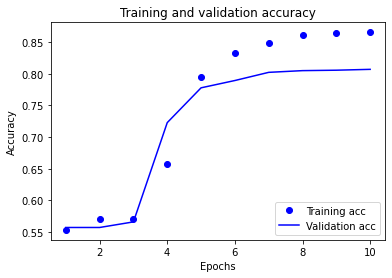

In [69]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [70]:
# batch_pipeline = BatchPipeline(dataset, submission_test_dataset, batch_size)
# predictions = base_model.predict_for_kaggle(batch_pipeline.submission_test_dataset)
# print(f"Predictions: {predictions}")

In [71]:
# submission_test_dataframe = data_pipeline.get_dataframe_from_csv(sample_submission_file_name).fillna(" ")
#
# utils.create_submission_for_kaggle("kaggle_predictions_BaseModel.txt", submission_test_dataframe["id"].values, predictions)

In [72]:
# %load_ext tensorboard

In [73]:
# tensorboard --logdir logs/hyperparameter_tuning --port 5000